We have two variants of the tailstorm protocol.
- The old one, `tailstormll`, merges the summary with the last sub-block required to form this summary. In this protocol, there are only $k - 1$ sub-blocks per summary but the summary itself requires a proof-of-work.
- The new one, `tailstorm`, aligns with the paper. There are $k$ sub-blocks per summary. Summaries do not require a proof-of-work. Summaries can be recreated locally by all nodes.

In this notebook, I'll compare the two variants. I expect them to be very similar.

`tailstorm` gives a little bit more freedom to the participants. Everybody will try to form summaries such that they optimize their own rewards. Unfortunately the algorithm for selecting sub-blocks into a summary is expensive. Hence simulation performance can drop during training.

Theoretically, each `tailstorm` participants creates its own reward-maximizing summary. As long as there are no confirming sub-blocks, participants will never adopt a foreign summary because it cannot imply higher reward. As soon as there are confirming sub-blocks, participants stop disambiguating by reward. They will prefer the summary with more confirmations. Now, since no receiver will ever prefer a received summary, it does not make sense to send them around. It's enough to send them together with the first confirming sub-block.

This leads to `tailstormll` which integrates the summary with the first confirming sub-block. The sub-block selection algorithm is still expensive, but it is only called on the node who mines the summary.

In [1]:
import cpr_gym
import itertools
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings

from pandarallel import pandarallel

pandarallel.initialize(use_memory_fs=False, progress_bar=True)

print(cpr_gym.engine.cpr_lib_version)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-142-ge6ffb1b-dirty (engine: ~)
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
~


## Generate Data
I run a lot of simulations for all combinations of
- protocol implementation
- k
- reward scheme
- alpha
- hard-coded policy

In [2]:
protocol_dict = dict(
    old=cpr_gym.protocols.tailstormll,
    new=cpr_gym.protocols.tailstorm,
)

alpha = [0.1, 0.25, 0.33, 0.45, 0.66]
episode_len = [8, 16, 32, 64, 128, 256]
k = [2, 4, 8]
reward_scheme = ["constant", "discount"]


def sparse(episode_len=100, protocol=None, reward_scheme="constant", k=8, **kwargs):
    env = gym.make(
        "cpr_gym:core-v0",
        proto=protocol_dict[protocol](
            reward=reward_scheme,
            k=k,
            subblock_selection="heuristic",
            unit_observation=True,
        ),
        **kwargs,
        max_steps=episode_len,
    )
    env = cpr_gym.wrappers.SparseRewardPerProgressWrapper(env)
    return env


def run_episode(env, policy=None):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    acc = 0
    done = False
    while not done:
        obs, reward, done, info = env.step(p(obs))
        acc += reward
    info["episode_reward"] = acc
    return info


def measure(n_episodes=1, policy="honest", **kwargs):
    env = sparse(**kwargs)
    reward = []
    chaintime = []
    starttime = time.time()
    for i in range(n_episodes):
        try:
            info = run_episode(env, policy=policy)
            reward.append(info["episode_reward"] / kwargs["alpha"])
            chaintime.append(info["episode_chain_time"])
        except ValueError as e:
            warnings.warn(str(e))
            print(kwargs)
            print(f"policy: {policy}")
            print(e)
    return [np.median(reward), np.median(chaintime), time.time() - starttime]


# create dataframe d with simulation parameters
dfs = []
for protocol in protocol_dict.keys():
    env = sparse(protocol=protocol)
    df = pd.DataFrame(
        itertools.product(
            [protocol], reward_scheme, k, alpha, episode_len, env.policies()
        ),
        columns=["protocol", "reward_scheme", "k", "alpha", "episode_len", "policy"],
    )
    dfs.append(df)

d = pd.concat(dfs, ignore_index=True)
d["n_episodes"] = [int(np.ceil(8096 / h)) for h in d.episode_len]

# run simulations
d[["reward", "chaintime", "walltime"]] = d.parallel_apply(
    lambda x: pd.Series(measure(**x)),
    axis=1,
)
d = d.assign(protocol_args=d.reward_scheme + "-" + d.k.map(str))
d

protocol reward_scheme  k  alpha  episode_len            policy  \
0         old      constant  2   0.10            8  override-catchup   
1         old      constant  2   0.10            8    override-block   
2         old      constant  2   0.10            8     release-block   
3         old      constant  2   0.10            8            honest   
4         old      constant  2   0.10           16  override-catchup   
...       ...           ... ..    ...          ...               ...   
1435      new      discount  8   0.66          128            honest   
1436      new      discount  8   0.66          256        avoid-loss   
1437      new      discount  8   0.66          256       minor-delay   
1438      new      discount  8   0.66          256         get-ahead   
1439      new      discount  8   0.66          256            honest   

      n_episodes    reward   chaintime  walltime protocol_args  
0           1012  0.000000    7.819697  0.533117    constant-2  
1           1012  0.000000    8.332955  0.411490    constant-2  
2           1012  0.000000    7.899566  0.478329    constant-2  
3           1012  1.250000    7.612902  0.483303    constant-2  
4            506  0.000000   15.811415  0.363105    constant-2  
...          ...       ...         ...       ...           ...  
1435          64  1.007846  112.090163  0.426503    discount-8  
1436          32  1.476584  221.327335  0.470479    discount-8  
1437          32  1.198509  205.092834  0.497965    discount-8  
1438          32  1.189350  218.858605  0.476855    discount-8  
1439          32  1.028139  226.814090  0.421433    discount-8  

[1440 rows x 11 columns]

## Walltime

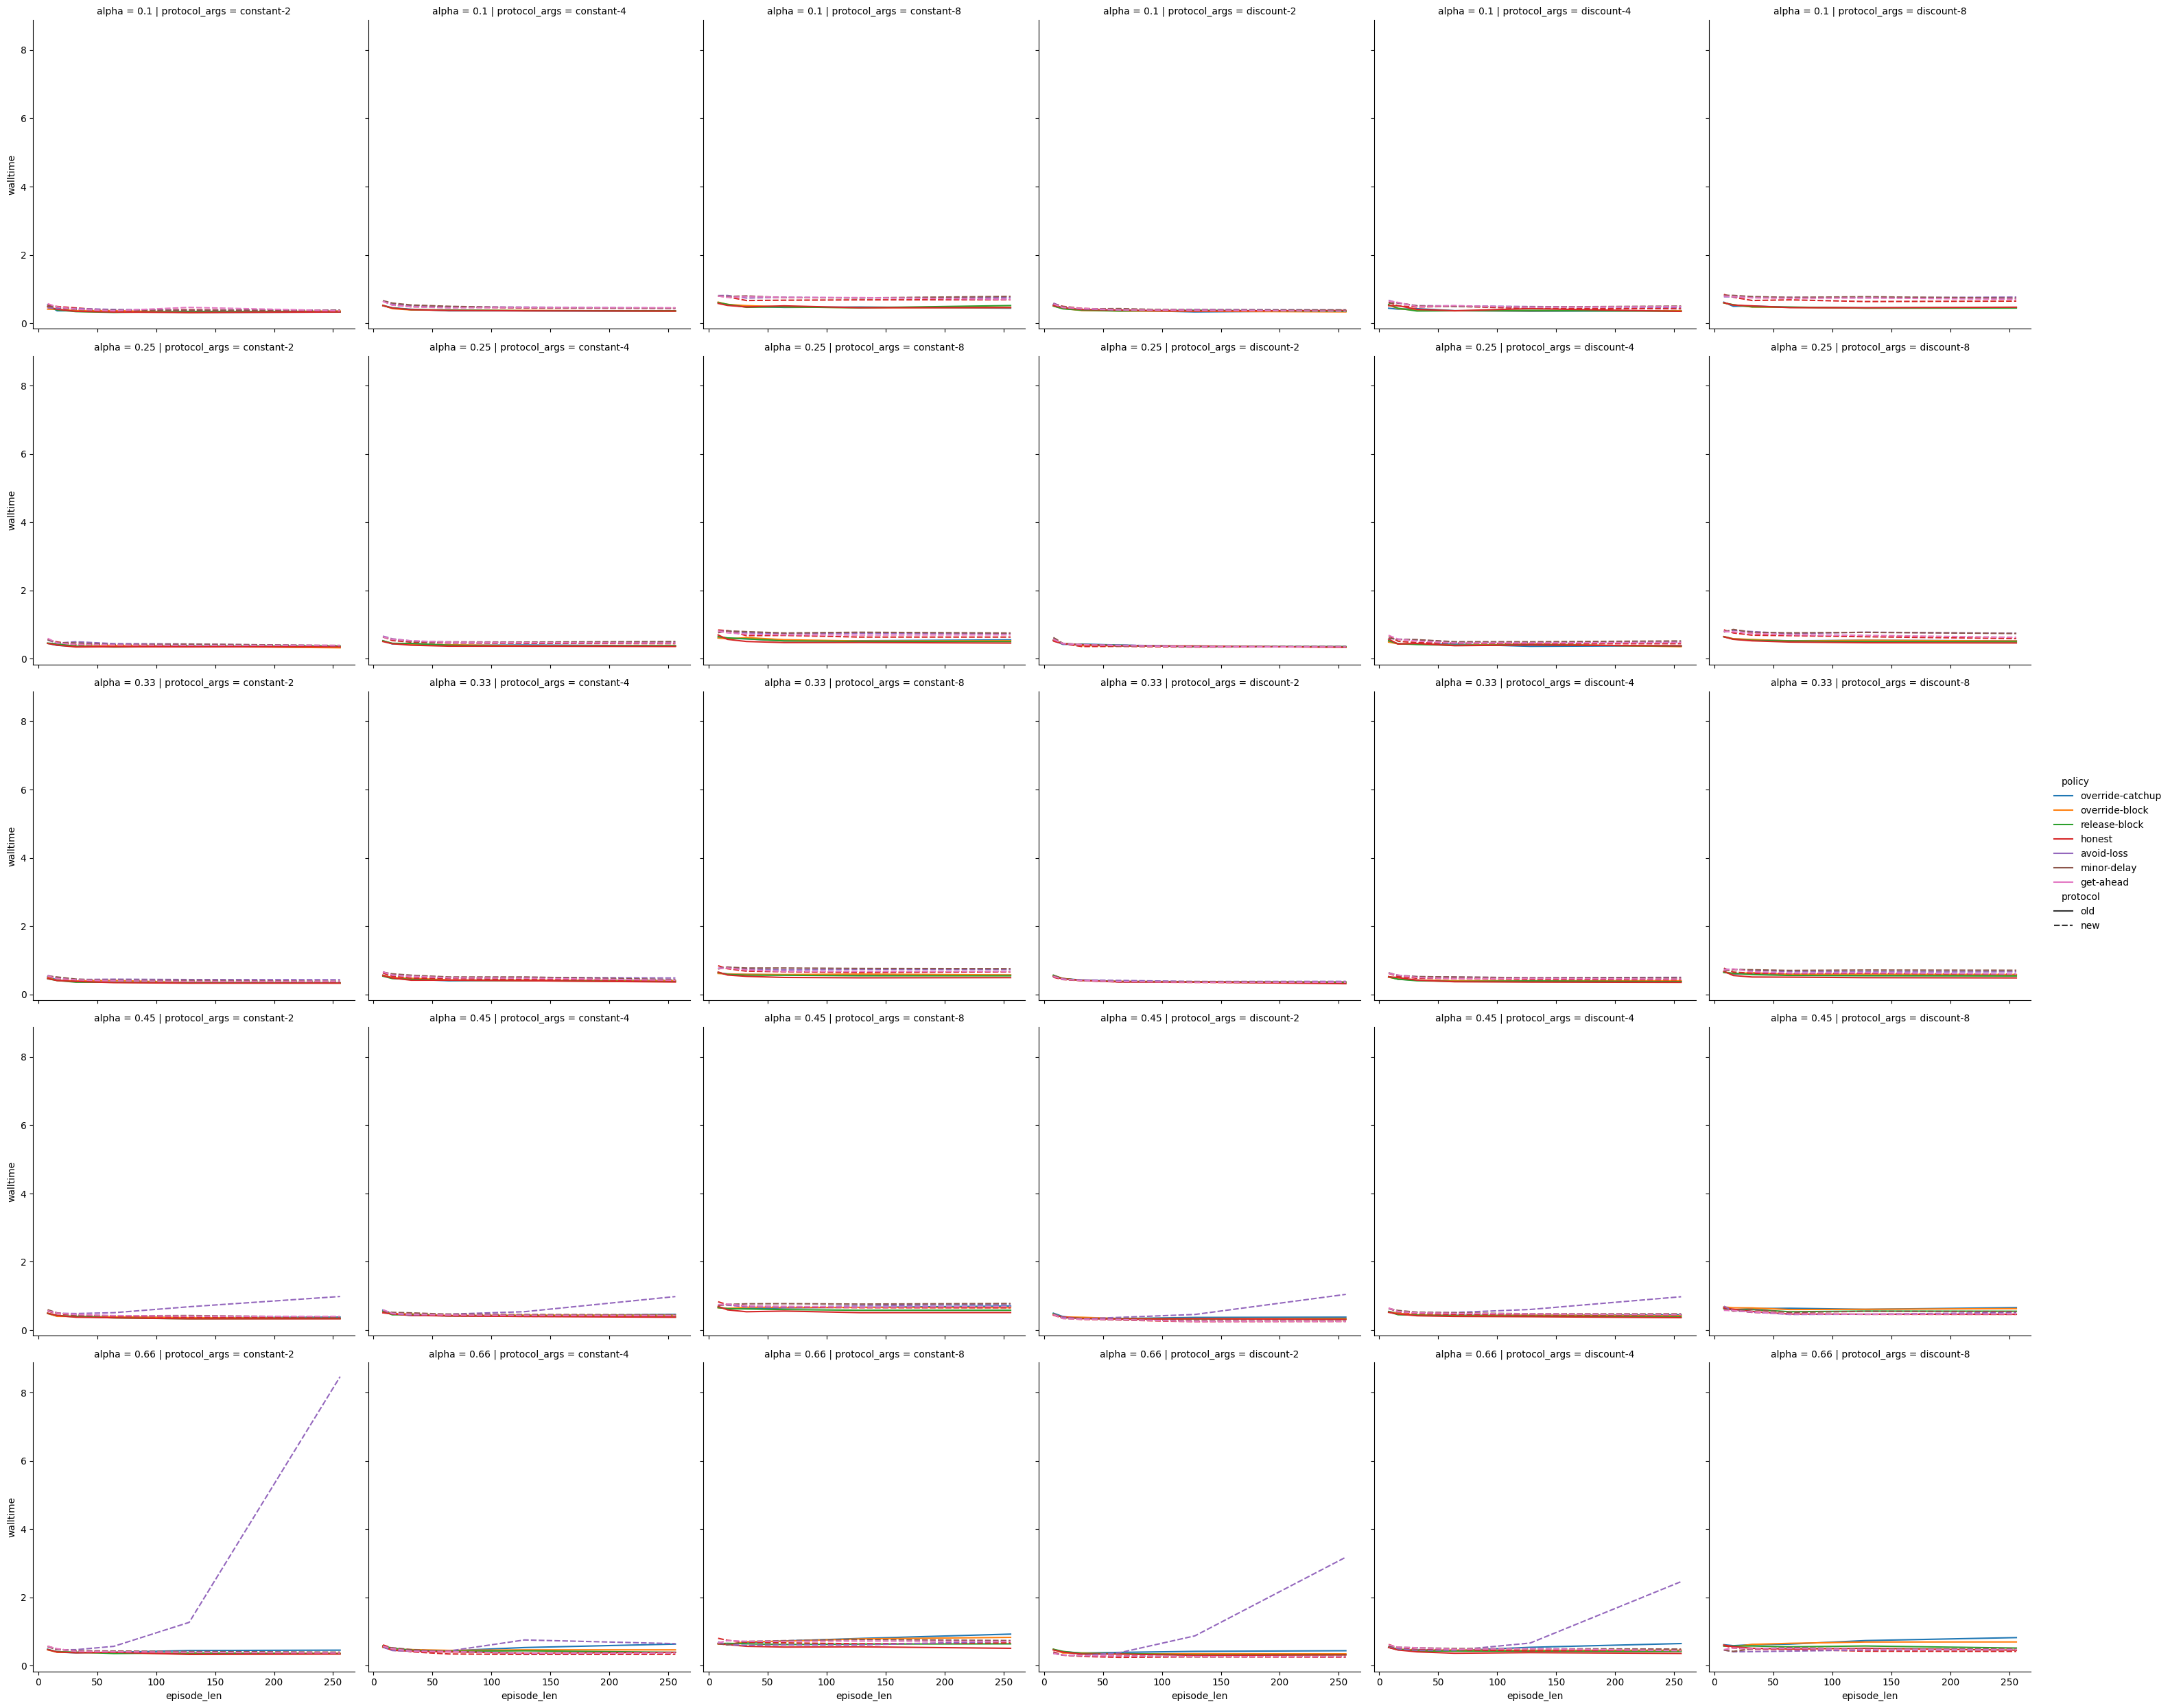

In [3]:
sns.relplot(
    data=d,
    kind="line",
    x="episode_len",
    y="walltime",
    hue="policy",
    style="protocol",
    row="alpha",
    col="protocol_args",
)

## Chaintime

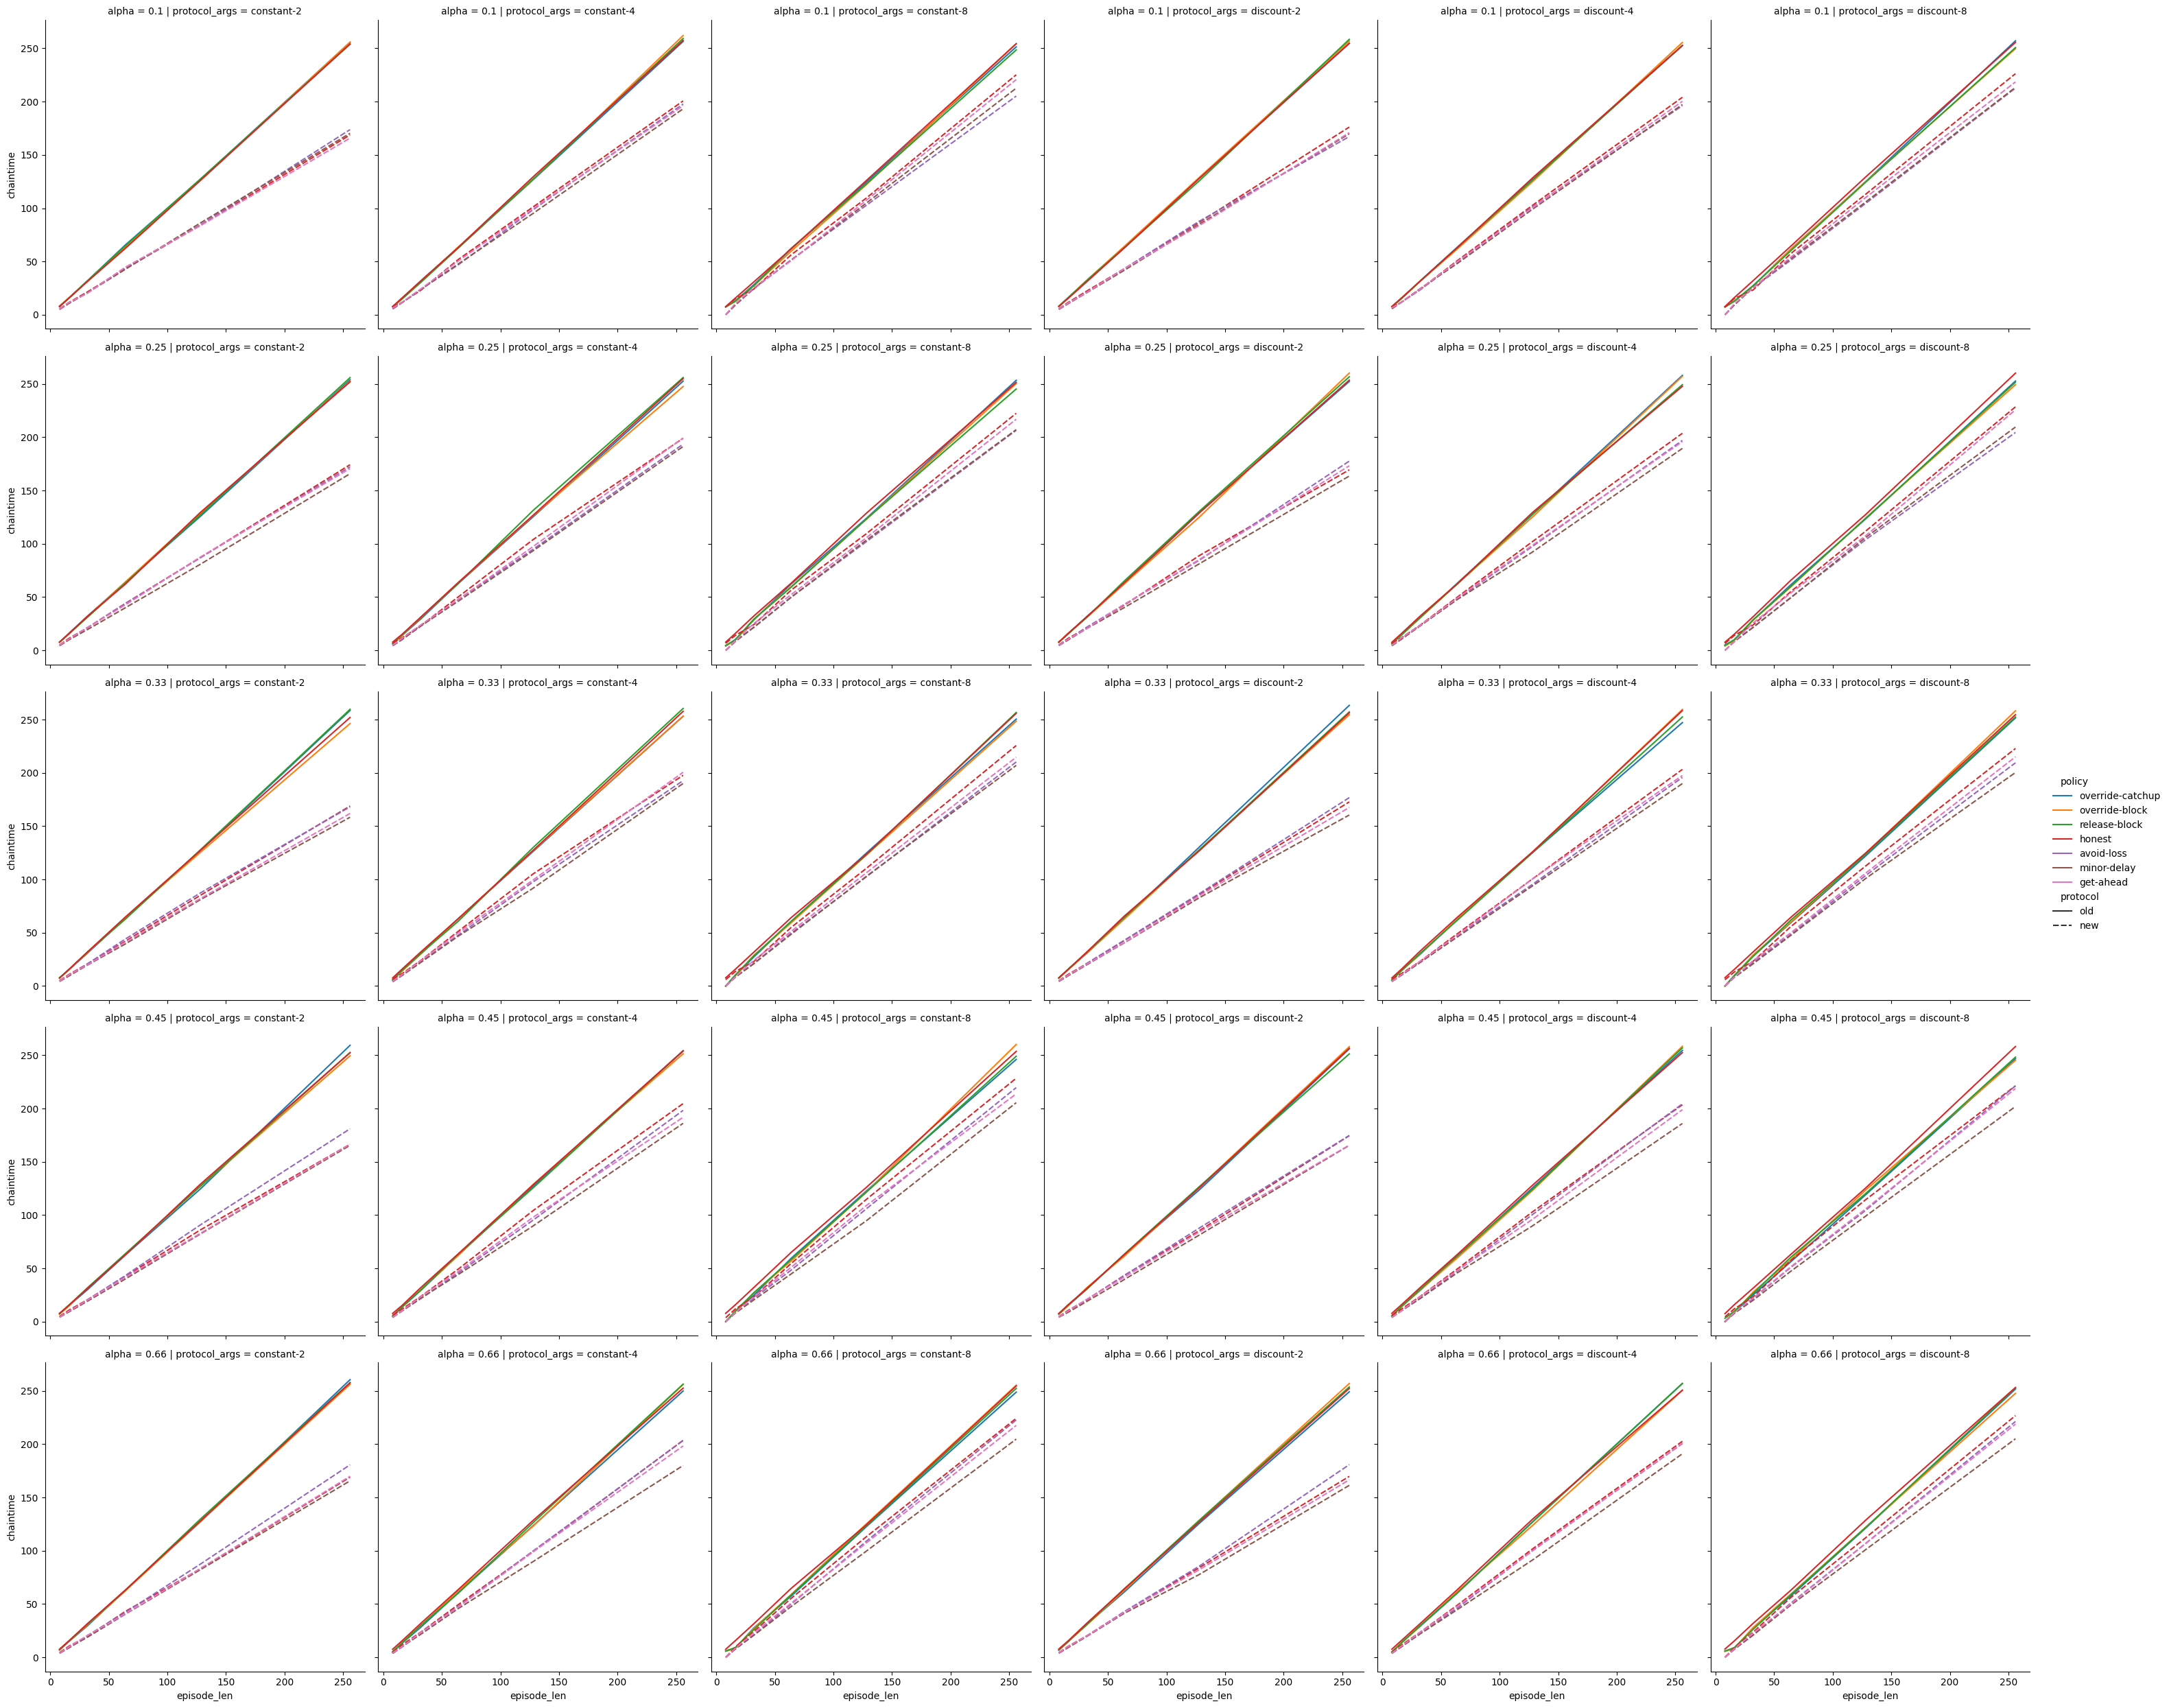

In [4]:
sns.relplot(
    data=d,
    kind="line",
    x="episode_len",
    y="chaintime",
    hue="policy",
    style="protocol",
    row="alpha",
    col="protocol_args",
)

## Reward

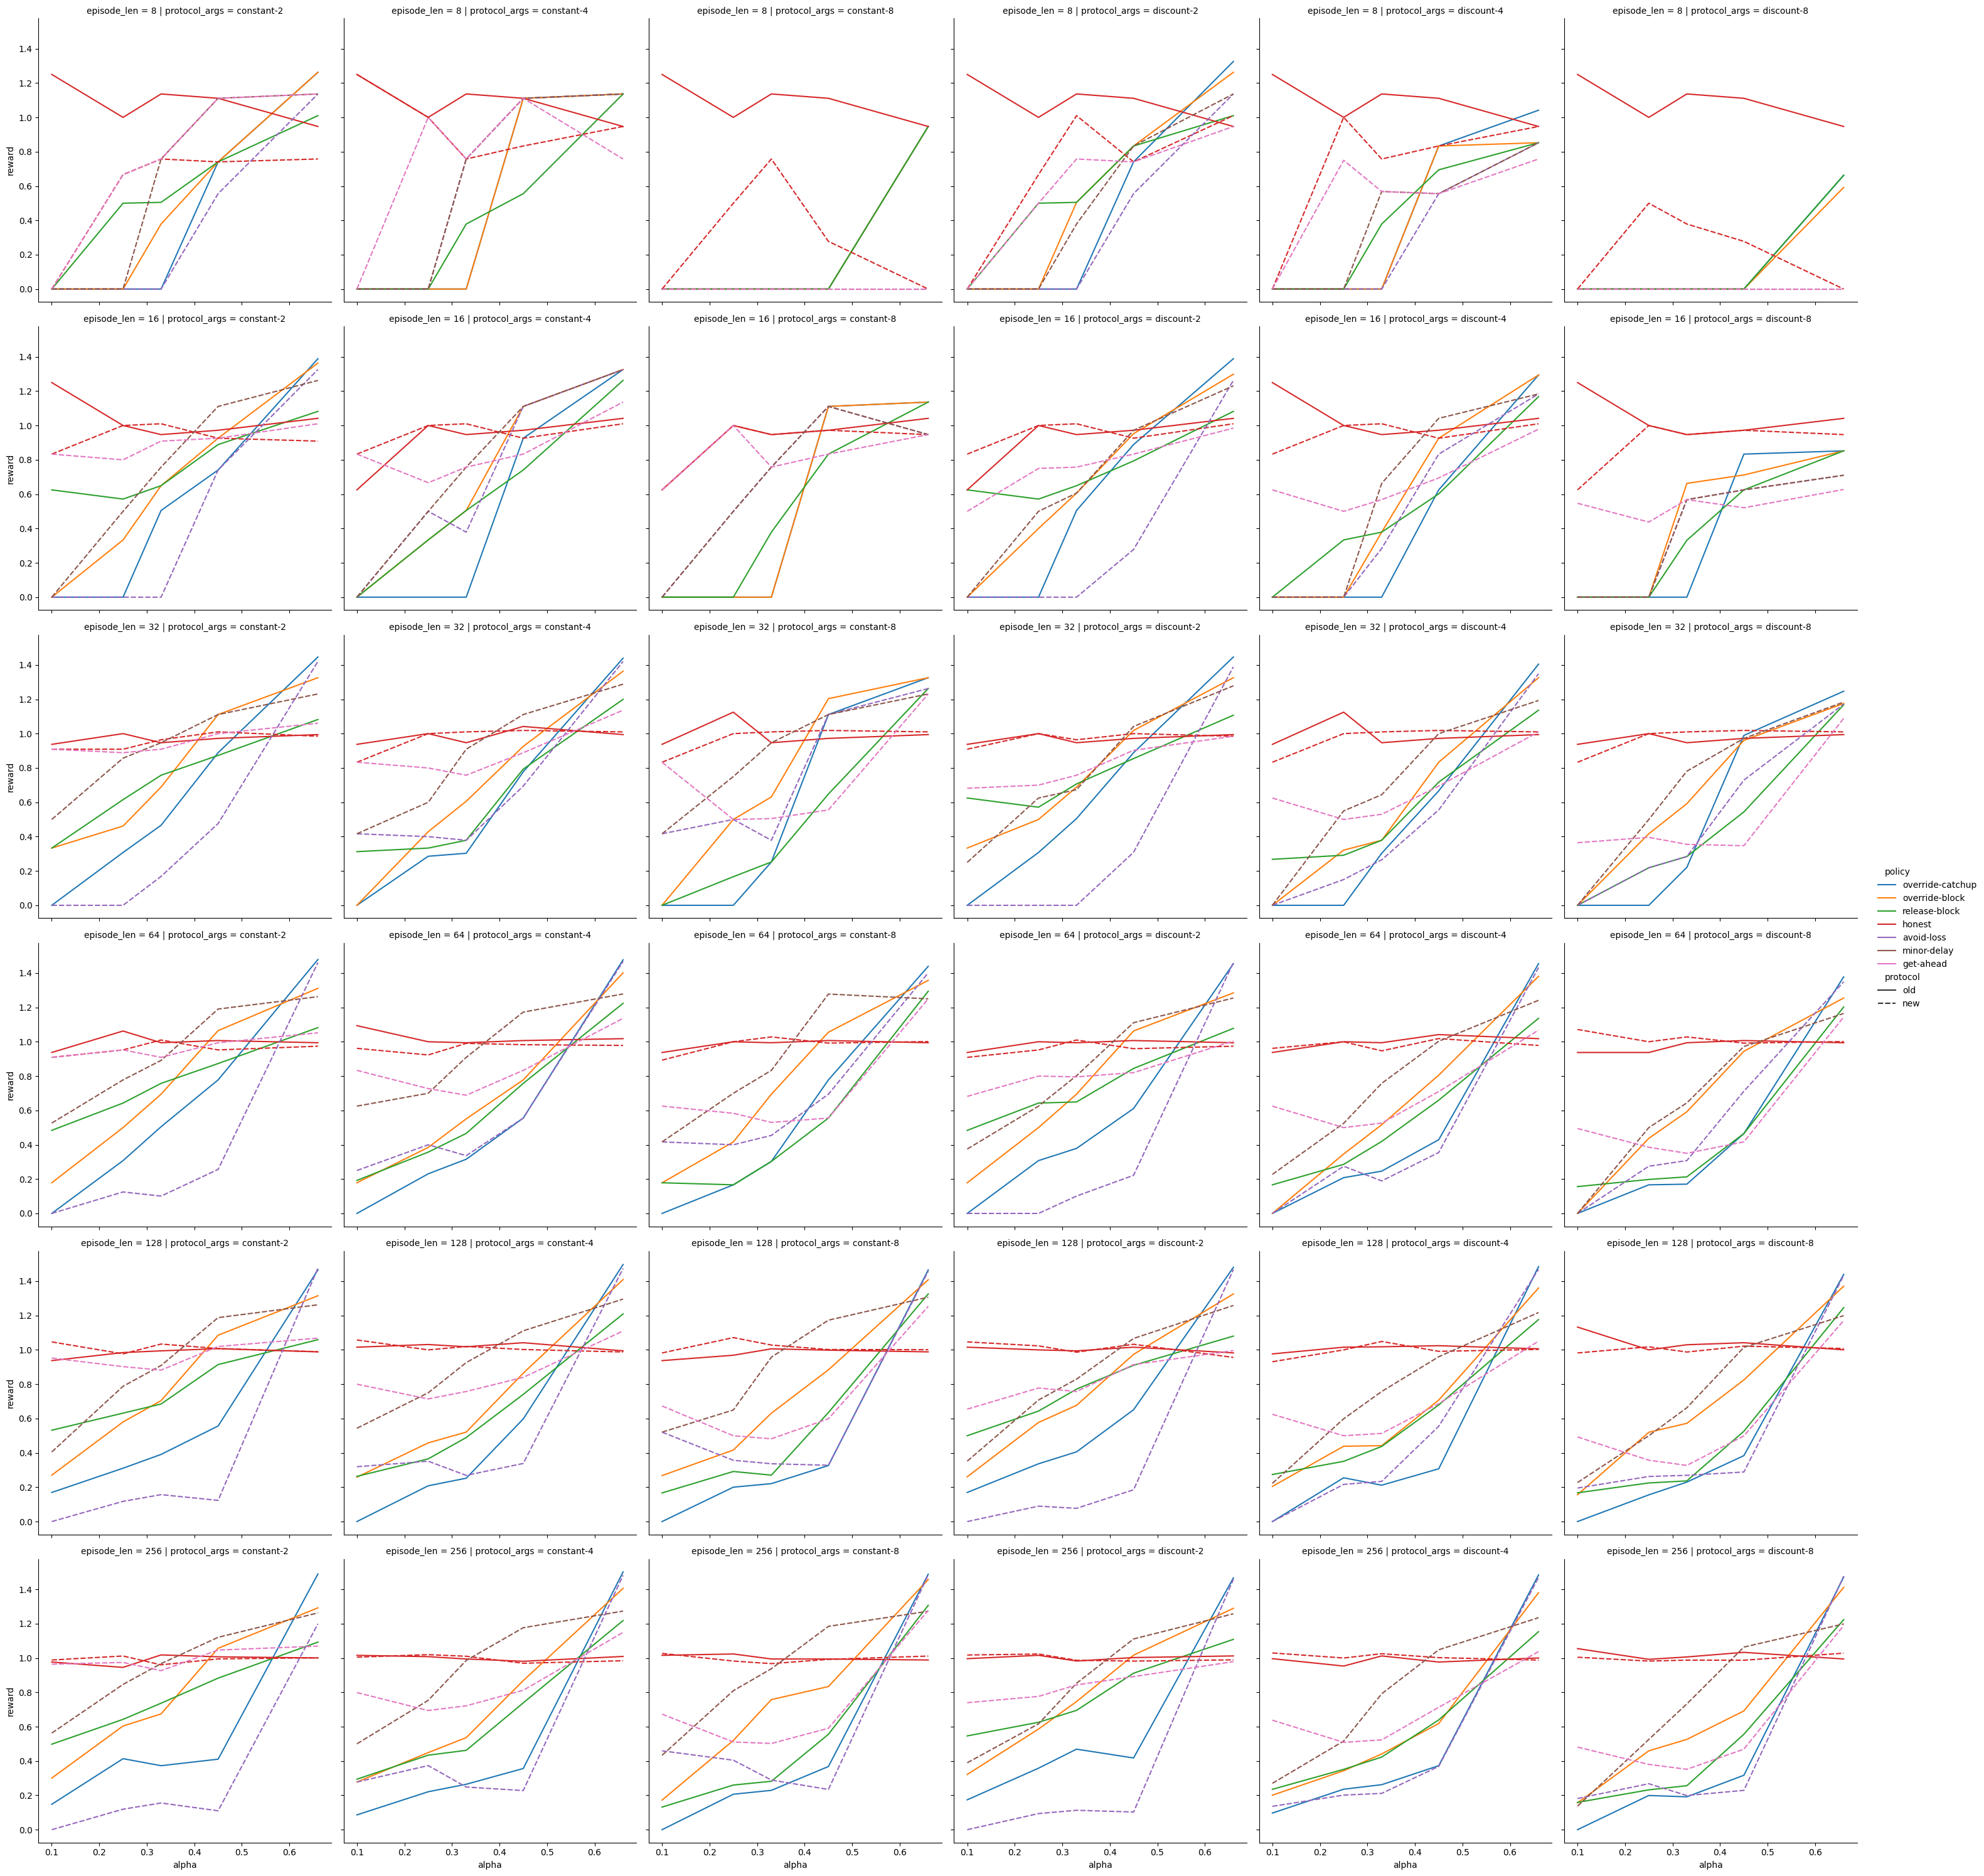

In [5]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    style="protocol",
    row="episode_len",
    col="protocol_args",
)

This reward plot looks a bit noisy. Let's try to regenerate the last row in more detail.

In [6]:
k = [4, 8]
alpha = [0.25, 0.3, 0.35, 0.4, 0.45]
# create dataframe d with simulation parameters
dfs = []
for protocol in protocol_dict.keys():
    env = sparse(protocol=protocol)
    df = pd.DataFrame(
        itertools.product([protocol], reward_scheme, k, alpha, [256], env.policies()),
        columns=["protocol", "reward_scheme", "k", "alpha", "episode_len", "policy"],
    )
    dfs.append(df)

d2 = pd.concat(dfs, ignore_index=True)
d2["n_episodes"] = [int(np.ceil(8096 * 10 / h)) for h in d2.episode_len]

# run simulations
d2[["reward", "chaintime", "walltime"]] = d2.parallel_apply(
    lambda x: pd.Series(measure(**x)),
    axis=1,
)
d2 = d2.assign(protocol_args=d2.reward_scheme + "-" + d2.k.map(str))
d2

protocol reward_scheme  k  alpha  episode_len            policy  \
0        old      constant  4   0.25          256  override-catchup   
1        old      constant  4   0.25          256    override-block   
2        old      constant  4   0.25          256     release-block   
3        old      constant  4   0.25          256            honest   
4        old      constant  4   0.30          256  override-catchup   
..       ...           ... ..    ...          ...               ...   
155      new      discount  8   0.40          256            honest   
156      new      discount  8   0.45          256        avoid-loss   
157      new      discount  8   0.45          256       minor-delay   
158      new      discount  8   0.45          256         get-ahead   
159      new      discount  8   0.45          256            honest   

     n_episodes    reward   chaintime  walltime protocol_args  
0           317  0.235294  253.763348  3.225484    constant-4  
1           317  0.460000  254.455305  3.473508    constant-4  
2           317  0.396226  254.944995  3.663393    constant-4  
3           317  1.000000  255.696912  3.769669    constant-4  
4           317  0.259259  254.537759  3.698610    constant-4  
..          ...       ...         ...       ...           ...  
155         317  0.993304  222.285991  5.241216    discount-8  
156         317  0.227865  217.600729  5.139371    discount-8  
157         317  1.020448  202.444035  4.672096    discount-8  
158         317  0.465593  218.824942  4.188178    discount-8  
159         317  1.011905  224.358428  4.097607    discount-8  

[160 rows x 11 columns]

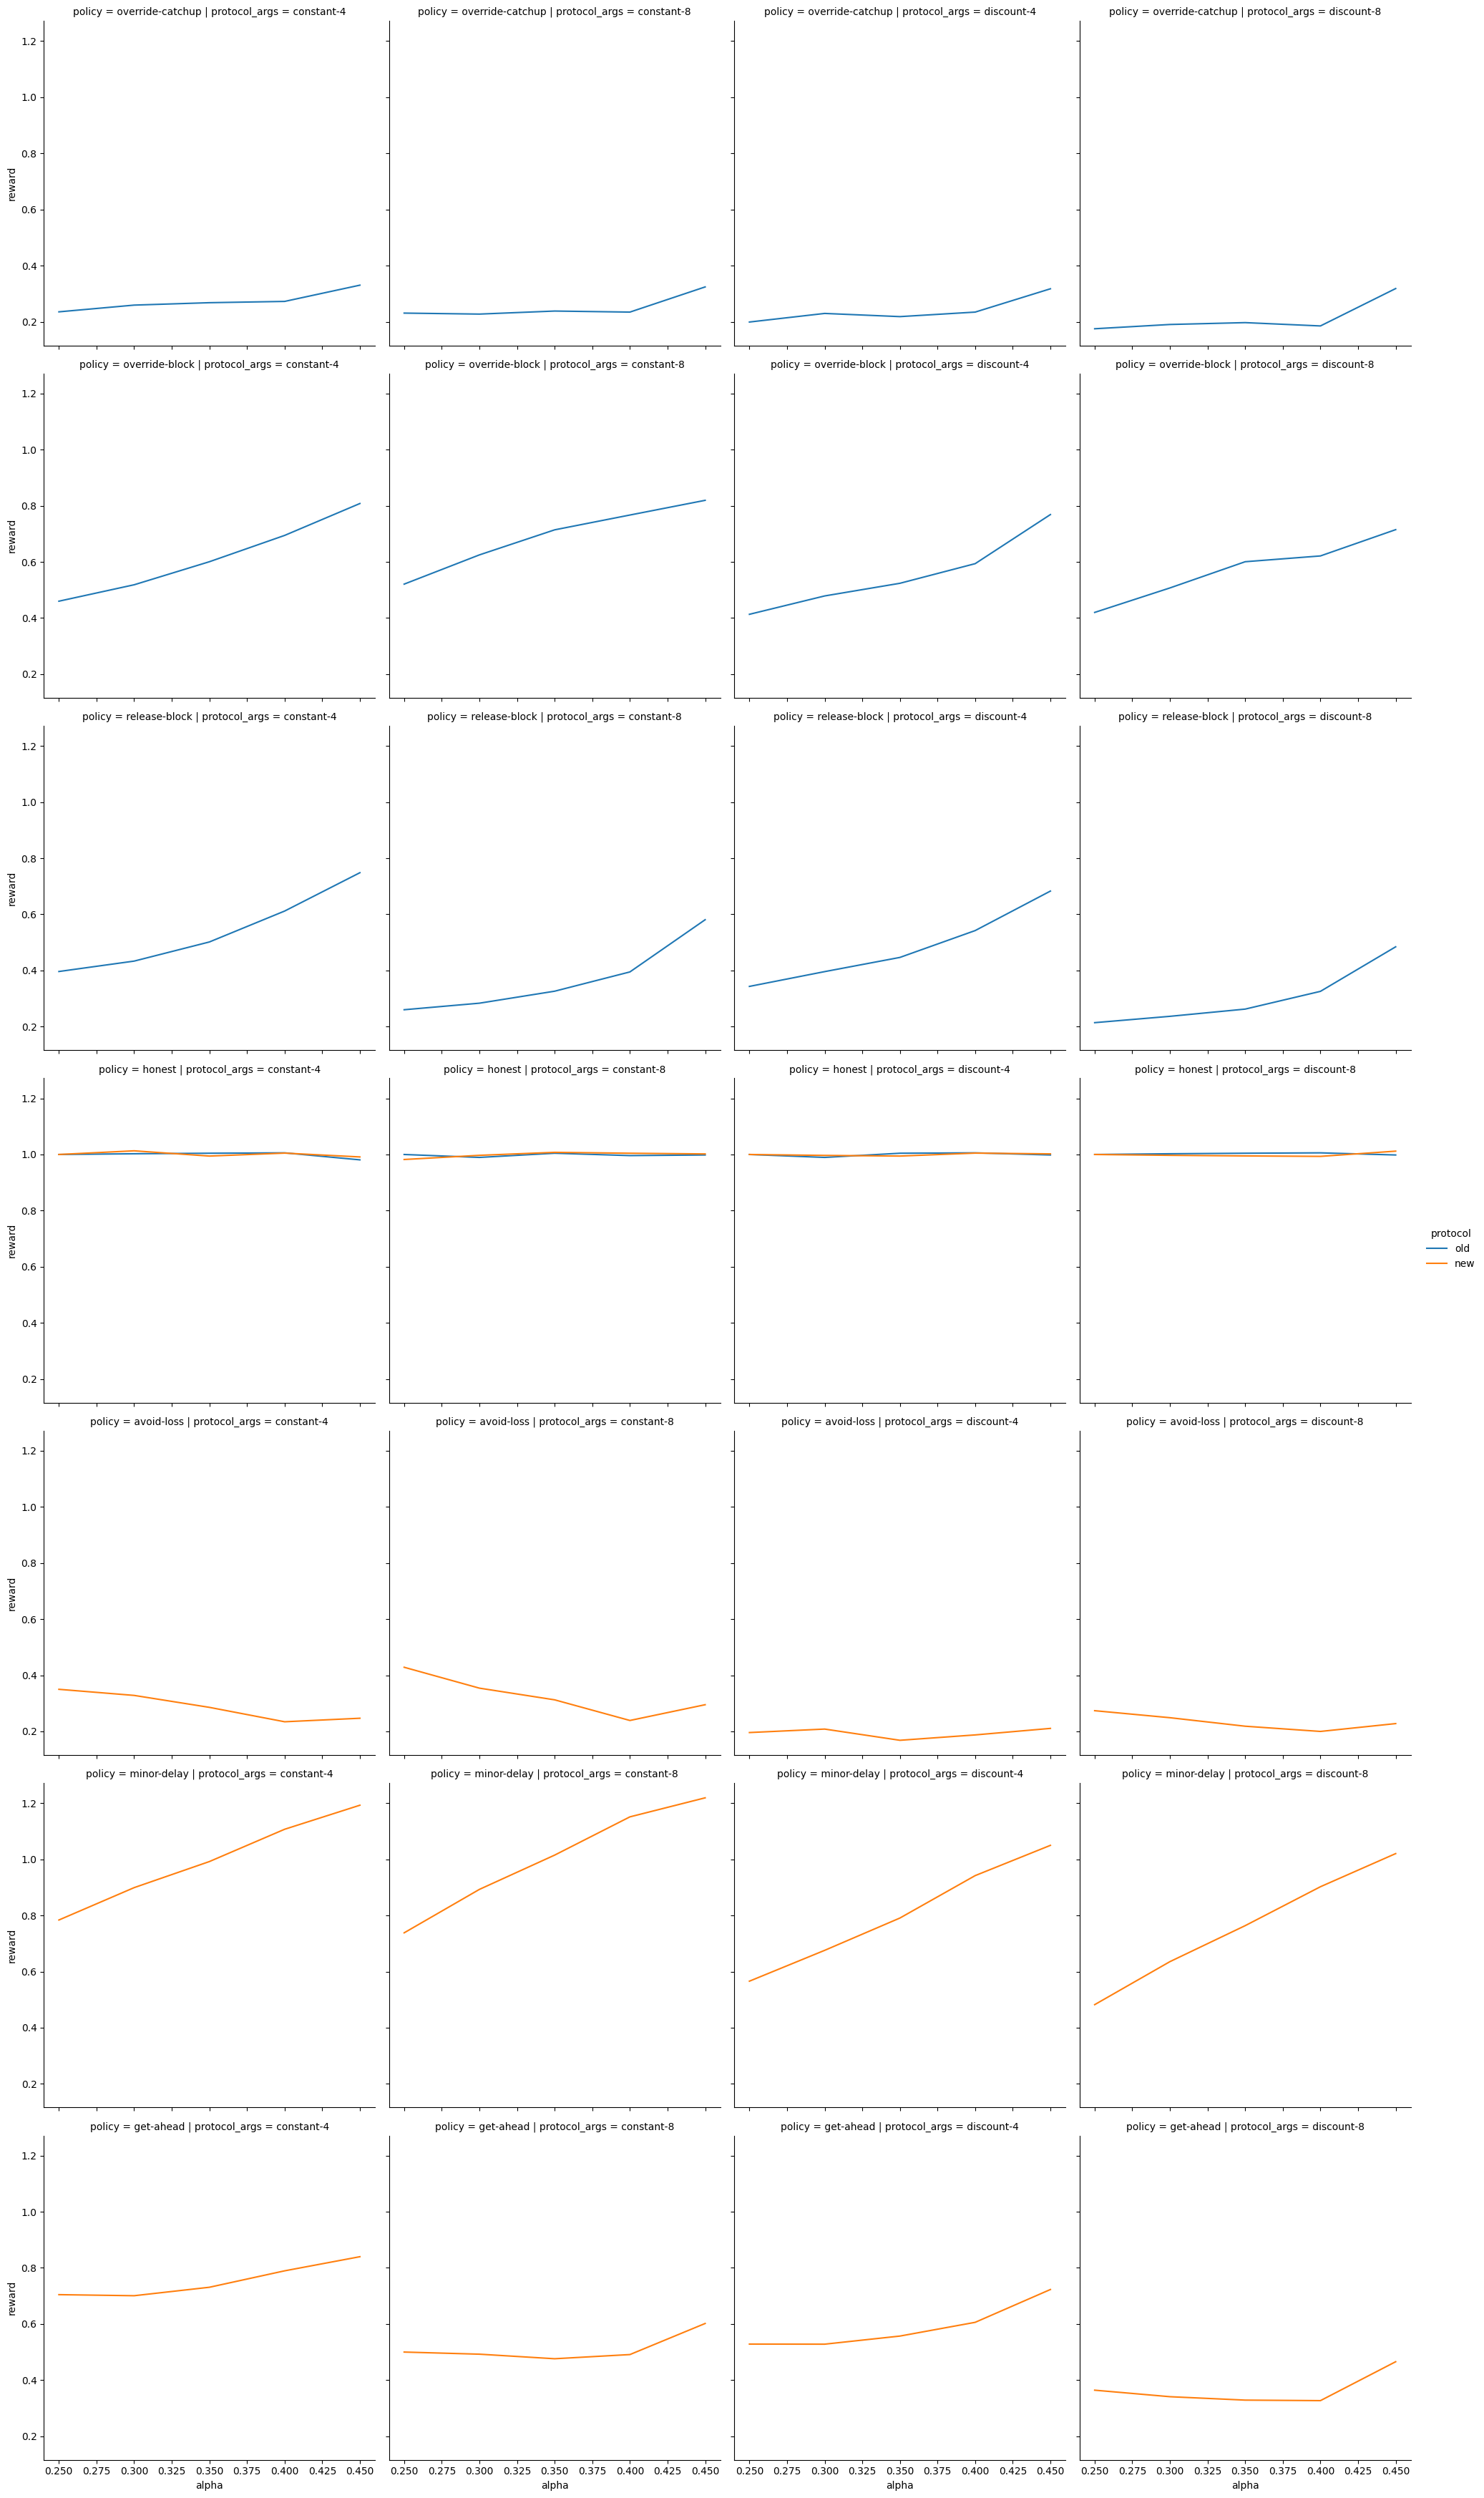

In [7]:
sns.relplot(
    data=d2,
    kind="line",
    x="alpha",
    y="reward",
    hue="protocol",
    row="policy",
    col="protocol_args",
)

Some policies do not align, but overall it seems that the implementations are equally exploitable. Let's double check by taking the maximum reward over all available policies. A trained agent should be at least as good.

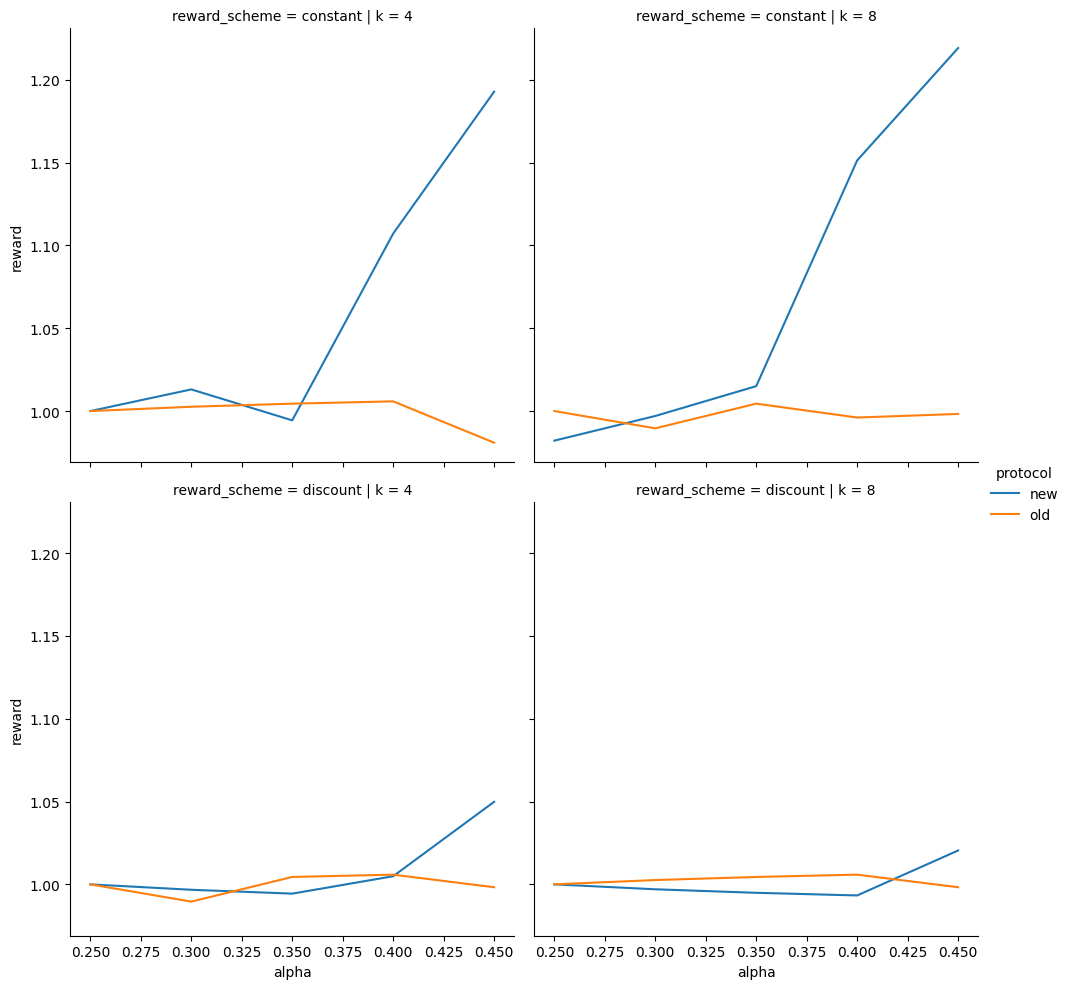

In [8]:
sns.relplot(
    data=d2.groupby(["alpha", "protocol", "reward_scheme", "k"]).agg(
        dict(reward="max")
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="protocol",
    row="reward_scheme",
    col="k",
)